In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from skimage.color import rgb2gray
import h5py

# **Generating slide and mask list**

We generate our slide and mask filenames list based on the inputs.

In [0]:
# Test slide removed

test_image_filename = '../vatsala-adl/tumor_110.tif'
test_mask_filename = '../vatsala-adl/tumor_110_mask.tif'

# get all filenames for slides and masks not in testing
slide_filenames = ['../vatsala-adl/tumor_101.tif','../vatsala-adl/tumor_078.tif']
mask_filenames = ['../vatsala-adl/tumor_101_mask.tif','../vatsala-adl/tumor_078_mask.tif']


slide_deck = []
mask_deck = []

# slides
for filename in slide_filenames:
    slide_deck.append(open_slide(filename))

# masks
for filename in mask_filenames:
    mask_deck.append(open_slide(filename))

print(slide_deck)
print(mask_deck)

[OpenSlide('../vatsala-adl/tumor_101.tif'), OpenSlide('../vatsala-adl/tumor_078.tif')]
[OpenSlide('../vatsala-adl/tumor_101_mask.tif'), OpenSlide('../vatsala-adl/tumor_078_mask.tif')]


In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked


# Preprocessing and Dataset creation

The first thing we need to do is consider only those subimages which are relevant. Here, based on a threshold value, we ignore the images that mostly are just grey background. To find whether or not an image is a potential background, we calculate the tissue percentage. For this we have created a helper function that returns tissue percentage in each image

In [0]:
def find_tissue_percentage(slide_region, window_size):
    
    image_width = window_size
    image_height = window_size

    def find_tissue_pixels(image, intensity=0.8):
        im_gray = rgb2gray(image)
        assert im_gray.shape == (image.shape[0], image.shape[1])
        indices = np.where(im_gray <= intensity)
        return list(zip(indices[0], indices[1]))
    
    tissue_pixels = find_tissue_pixels(slide_region)
    percent_tissue = len(tissue_pixels) / float(image_width * image_height) * 100
    
    return percent_tissue

Since our slide image is very big, we extract smaller patch images from the slide image. We decided to extract maintain separate lists of healthy and tumor images so that we could later on see what happens if we keep a balanced set.

In [0]:
def check_if_cancer(patch_mask, patch_centre):
    # detect patch size
    patch_size = patch_mask.shape[0]
    
    # get the offset to check the x*x centre
    offset = int((patch_size-patch_centre)/2)
    
    # sum the pixels in the x*x centre for the tumor mask
    sum_vals = np.sum(patch_mask[offset:offset+patch_centre, offset:offset+patch_centre])
    
    return sum_vals>0

In [0]:
def get_patches_from_images(slide, mask, level, window_size, stride):
  
    #patch_centre = 128
    
    tissue_threshold = 0.01
    tumor_image_deck = []
    tumor_mask_deck = []
    tumor_mask_labels = []
    healthy_image_deck = []
    healthy_mask_deck = []
    healthy_mask_labels = []
    
    #At slide level
    image_width = slide.level_dimensions[level][0]
    image_height = slide.level_dimensions[level][1]
    
    x_val = 0
    y_val = 0
    downsample_factor = int(slide.level_downsamples[level]) #2**level
    
    # Move window through the slide
    while y_val < (image_height - window_size + 1):
        print("fwd")
        while x_val < (image_width - window_size + 1):
            
            # slide image
            slide_region = read_slide(slide, 
                         x= x_val * downsample_factor, 
                         y= y_val * downsample_factor, 
                         level= level, 
                         width= window_size, 
                         height= window_size)
            
            # mask image
            mask_region = read_slide(mask, 
                         x= x_val * downsample_factor, 
                         y= y_val * downsample_factor, 
                         level= level, 
                         width= window_size, 
                         height= window_size)
            
            # one channel enough for mask
            mask_region = mask_region[:,:,0]

            # find label corresponding to the patch
            #reduced from 100 to 25 as per patch size
            cancer_present= check_if_cancer(mask_region, 50)
            #cancer_present = 1
            
            # ignore gray images without any tissue
            percent_tissue = find_tissue_percentage(slide_region, window_size)

            if percent_tissue > tissue_threshold:
                if cancer_present:
                    tumor_image_deck.append(slide_region)
                    tumor_mask_deck.append(mask_region)
                    tumor_mask_labels.append(1)
                else:
                    healthy_image_deck.append(slide_region)
                    healthy_mask_deck.append(mask_region)
                    healthy_mask_labels.append(0)
                  
            # move by stride
            x_val += stride
        
        # end of row, reset and move down by stride
        x_val = 0
        y_val += stride
        
    return tumor_image_deck, tumor_mask_deck, tumor_mask_labels, healthy_image_deck, healthy_mask_deck, healthy_mask_labels

The below is run for each level separately - comments about experiments done

In [0]:
# taken size at 100 instead of 299, as kept crashing
window_size = 150
stride = 10
level = 5

slide_subimages = []
slide_submasks = []
slide_sublabels = []
slide_tumor_subimages = []
slide_tumor_submasks = []
slide_tumor_sublabels = []
slide_healthy_subimages = []
slide_healthy_submasks = []
slide_healthy_sublabels = []

for ind in range(2):
    print(ind)
    tumor_subimages, tumor_submasks, tumor_sublabels, healthy_subimages, healthy_submasks, healthy_sublabels = get_patches_from_images(slide_deck[ind], mask_deck[ind], level, window_size, stride)
    slide_tumor_subimages.extend(tumor_subimages)
    slide_tumor_submasks.extend(tumor_submasks)
    slide_tumor_sublabels.extend(tumor_sublabels)
    slide_healthy_subimages.extend(healthy_subimages)
    slide_healthy_submasks.extend(healthy_submasks)
    slide_healthy_sublabels.extend(healthy_sublabels)

print(len(slide_tumor_subimages), len(slide_healthy_subimages))

0
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
fwd
1
fwd
fwd
fwd
fwd
fwd
fwd
fwd


# Data Imbalance 

As we can see, the data is highly skewed. We have far more samples of healthy subimages than tumor images. To remove some of the skewness, we randomly shuffle and drop some of the healthy samples.

As we do this for one level, we will also ensure that we drop out the samples for the corresponding zoomed in/zoomed out level

In [0]:
# slide_subimages.extend(slide_tumor_subimages)
# slide_subimages.extend(slide_healthy_subimages)


slide_healthy_subimages = np.array(slide_healthy_subimages)
slide_tumor_subimages = np.array(slide_tumor_subimages)
n_healthy = len(slide_healthy_subimages)
n_tumor = len(slide_tumor_subimages)
# n_h = min(n_tumor*4, n_healthy//3)

randomize = np.arange(n_healthy)
np.random.shuffle(randomize)
slide_healthy_subimages = slide_healthy_subimages[randomize]
slide_healthy_subimages = slide_healthy_subimages[0:n_healthy//10,:]
slide_healthy_sublabels = slide_healthy_sublabels[0:n_healthy//10]

randomize = np.arange(n_tumor)
np.random.shuffle(randomize)
slide_tumor_subimages = slide_tumor_subimages[randomize]
slide_tumor_subimages = slide_tumor_subimages[0:n_tumor//10,:]
slide_tumor_sublabels = slide_tumor_sublabels[0:n_tumor//10]

slide_sublabels = []

slide_sublabels.extend(slide_tumor_sublabels)
slide_sublabels.extend(slide_healthy_sublabels)

print(len(slide_tumor_subimages), len(slide_healthy_subimages))
print(len(slide_healthy_sublabels))


2209 13825
13825


In [0]:

slide_sublabels = np.array(slide_sublabels)
dataset = []

dataset_slide_subimages = np.vstack((slide_tumor_subimages,slide_healthy_subimages))

print("Images for  : ", dataset_slide_subimages.shape)
print("Labels: ", slide_sublabels.shape)

Images for  :  (16034, 150, 150, 3)
Labels:  (16034,)


# **Save datasets for later loading**

In [0]:
np.save('train_subimages' + str(level), dataset_slide_subimages)
np.save('train_labels' + str(level), slide_sublabels)

# With Data Augmentation

To further make the set balanced, we will carry out transformations on tumor images and augment the data with them. 
The basic augmentations we try are -
1. flip horizontal
2. flip vertical
3. flip horizontal and vertical 

This leads to 4x times the tumor image dataset collection!

Augmented dataset  (8836, 150, 150, 3)


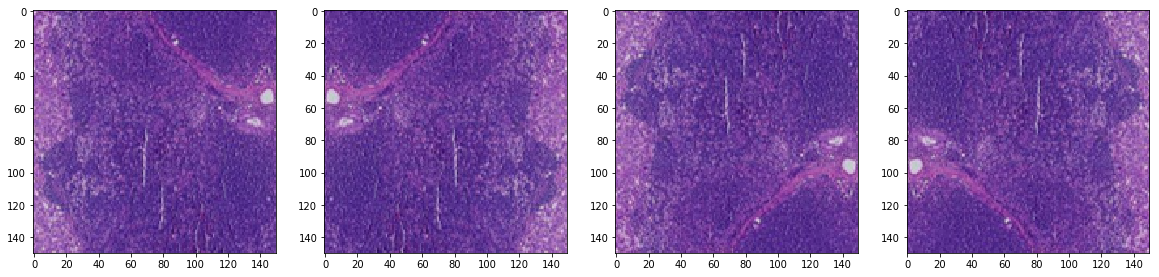

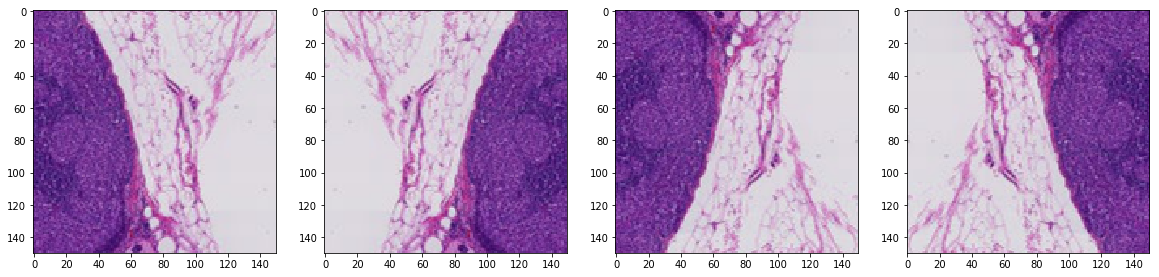

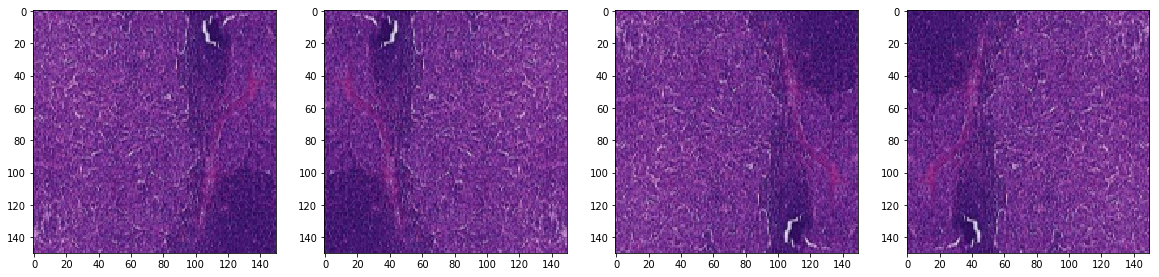

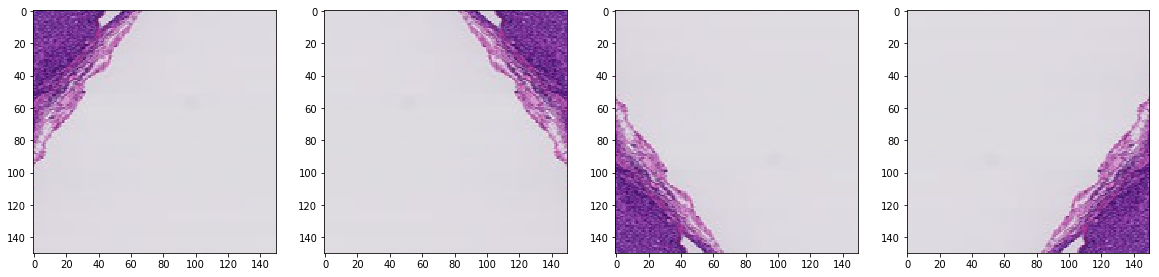

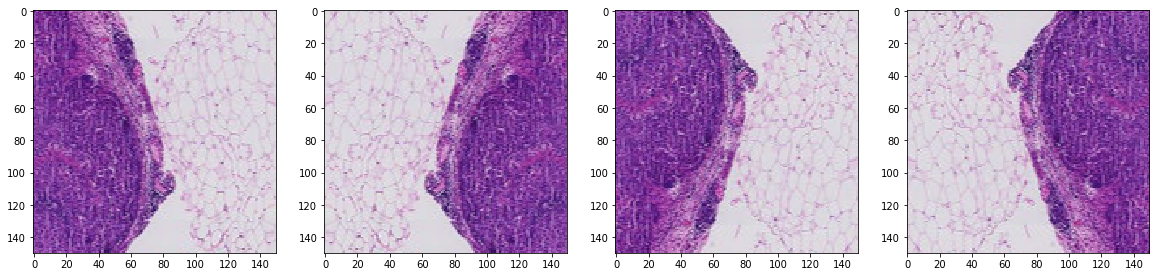

In [0]:
n_tumor = len(slide_tumor_subimages)
augmented = slide_tumor_subimages
if(n_tumor <15000):

    i=0
    for image in slide_tumor_subimages:
      i+=1

      lr = np.fliplr(image)  
      ud = np.flipud(image)
      lrud = np.flipud(lr) 

      if i<=5:
        fig, axes = plt.subplots(1,4, figsize=(20,5))
        a = axes[0]
        a.imshow(image)
        a.grid(False)
        a = axes[1]
        a.imshow(lr)
        a.grid(False)
        a = axes[2]
        a.imshow(ud)
        a.grid(False)
        a = axes[3]
        a.imshow(lrud)
        a.grid(False)

      image = np.expand_dims(image,axis = 0)
      #print(image.shape)
      lr = np.expand_dims(lr,axis = 0)
      #print(lr.shape)
      ud = np.expand_dims(ud,axis = 0)
      #print(ud.shape)
      lrud = np.expand_dims(lrud,axis = 0)
      #print(lrud.shape)
      augmented = np.vstack((augmented,ud))
      augmented = np.vstack((augmented,lr))
      augmented = np.vstack((augmented,lrud))

    print("Augmented dataset ", augmented.shape)



Next, we drop images from healthy set to almost balance this skewness

In [0]:
n_tumor = len(augmented)
n_h = n_healthy
if((n_h+200) < n_tumor):
    n_tumor = n_h
else:
    n_h = n_tumor + 200 

slide_healthy_subimages_augmented = slide_healthy_subimages[0:n_h,:]

randomize = np.arange(n_tumor)
np.random.shuffle(randomize)
augmented = augmented[randomize]
augmented = augmented[1:n_tumor,:]

augmented_dataset_images = np.vstack((augmented,slide_healthy_subimages_augmented))
augmented_dataset_labels = []

augmented_dataset_labels.extend([1 for i in range(len(augmented))])
augmented_dataset_labels.extend([0 for i in range(len(slide_healthy_subimages_augmented))])

In [0]:
print("New tumor images  : ", augmented.shape)
print("New healthy images: ", slide_healthy_subimages_augmented.shape)

augmented_dataset_labels = np.array(augmented_dataset_labels)
print("Labels: ", len(augmented_dataset_labels))

New tumor images  :  (8835, 150, 150, 3)
New healthy images:  (9036, 150, 150, 3)
Labels:  17871


# **Save datasets for later loading**

In [0]:
np.save('train_subimages_augmented' + str(level), augmented_dataset_images)
np.save('train_labels_augmented' + str(level), augmented_dataset_labels)